# Классификация одежды с Keras

Будем использовать Fashion MNIST

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)
import keras
import keras.models as M
import keras.layers as L
import keras.backend as K
print("We are using Keras", keras.__version__)
import pandas as pd

We're using TF 2.0.0
We are using Keras 2.3.1


Using TensorFlow backend.


# Загрузим данные

Классы:
```
0 T-shirt/top 
1 Trouser 
2 Pullover 
3 Dress 
4 Coat 
5 Sandal 
6 Shirt 
7 Sneaker 
8 Bag 
9 Ankle boot
```




In [2]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 3s 1us/step


In [3]:
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[9 0 0 3 0 2 7 2 5 5]
[9 2 1 1 6 1 4 6 5 7]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


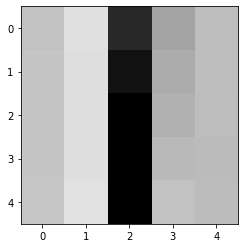

Пример картинки:


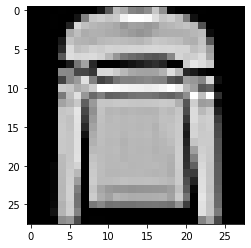

y_train [shape (60000,)] 10 примеров:
 [9 0 0 3 0 2 7 2 5 5]


In [4]:
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

In [5]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9 0 0 3 0]


# Собираем модель

Допустим, мы хотим настроить линейный классификатор $\vec{x} \rightarrow y$ с SGD в Keras.

Сначала надо будет посчитать логиты (logit, линейное преобразование) $z_k$ для каждого класса: $$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

А затем превратить логиты $z_k$ в вероятности $p_k$ при помощи функции softmax: $$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

Мы будем использовать cross-entropy для минимизации ошибки: $$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$

где $$ [x]=\begin{cases} 1, \quad \text{если $x$ истина} \\ 0, \quad \text{иначе} \end{cases} $$

Минимизация cross-entropy двигает $p_k$ в сторону 1 когда $y = k$, что как раз мы и хотим.

In [6]:
K.clear_session()

# пока мы не изучили сверточные сети, не будем их использовать!
# вытянем картинку в вектор размера 28*28=784 и будем использовать это как фичи!
# рекомендуем использовать активацию L.Activation('elu') на скрытых слоях, пока поверьте наслово, что elu лучше :)
# не забудьте 10 выходов с активацией softmax на выходном слое!
model = M.Sequential()
model.add(L.Dense(128, input_shape=(28*28,)))
model.add(L.Activation('elu'))
model.add(L.Dense(128))
model.add(L.Activation('elu'))
model.add(L.Dense(10))
model.add(L.Activation('softmax'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
________________________________________________

In [8]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [9]:
# центрируем и нормируем, так сети будет проще учиться
x_train_float = x_train.astype(np.float) / 255 - 0.5
x_val_float = x_val.astype(np.float) / 255 - 0.5

# попробуйте пропустить нормирование и посмотрите что будет :)
# x_train_float = x_train.astype(np.float)
# x_val_float = x_val.astype(np.float)

In [10]:
%%time
model.fit(
    x_train_float.reshape(-1, 28*28), 
    y_train_oh,
    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
    epochs=10,  # 10 проходов по датасету
    validation_data=(x_val_float.reshape(-1, 28*28), y_val_oh)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 107us/step - loss: 0.4965 - accuracy: 0.8203 - val_loss: 0.4233 - val_accuracy: 0.8423
Epoch 2/10
60000/60000 [==============================] - 6s 104us/step - loss: 0.3809 - accuracy: 0.8602 - val_loss: 0.3888 - val_accuracy: 0.8577
Epoch 3/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.3446 - accuracy: 0.8731 - val_loss: 0.3782 - val_accuracy: 0.8617
Epoch 4/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.3178 - accuracy: 0.8820 - val_loss: 0.3875 - val_accuracy: 0.8584
Epoch 5/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.2977 - accuracy: 0.8906 - val_loss: 0.3548 - val_accuracy: 0.8736
Epoch 6/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.2837 - accuracy: 0.8947 - val_loss: 0.3397 - val_accuracy: 0.8758
Epoch 7/10
60000/60000 [==============================] - 7s 1

Что вам необходимо проделать:
1. Обучите сеть без скрытых слоев. **Какое accuracy на валидации получили?**
2. Обучите сеть с двумя скрытыми слоями по 128 нейронов в каждом. **Какое accuracy на валидации получили?**
3. **Сколько параметров в последней сети?**

Удачи!